# geopandas spatial join example

By [Ben Welsh](mailto:ben.welsh@gmail.com)

How to use geopandas' spatial join to combine point and polygon data.

This example merges sightings of unidentified flying objects [compiled by the National UFO Reporting Center](https://github.com/planetsig/ufo-reports) with the outline of U.S. counties. It then analyzes what counties have reported the most sightings per capita.

In [13]:
import shapely
import calculate
import statestyle
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
%matplotlib inline

## Read the the point data: UFO sightings

In [16]:
point_df = pd.read_csv(
    "./input/ufo-scrubbed-geocoded-time-standardized.csv",
    names=[
        'observed',
        'city',
        'state',
        'country',
        'shape',
        'unknown',
        'duration',
        'description',
        'recorded',
        'lat',
        'lng'
    ]
)

In [17]:
print len(point_df)

80332


Convert the latitude and longitude fields to floats

In [18]:
point_df['lat'] = point_df.lat.apply(pd.to_numeric, args=('coerce',))
point_df['lng'] = point_df.lng.apply(pd.to_numeric, args=('coerce',))

Combine the latitude and longitude fields into a Point object

In [19]:
point_df['geometry'] = point_df.apply(lambda z: Point(z.lng, z.lat), axis=1)

Convert the DataFrame into a GeoDataFrame

In [20]:
point_gdf = gp.GeoDataFrame(point_df)

Set the coordinate system. It will need to match the polygon file.

In [21]:
point_gdf.crs

In [22]:
point_gdf.crs = {'init': u'epsg:4269'}

Exclude any invalid geometries

In [23]:
point_gdf = point_gdf[point_gdf.is_valid == True]

Invalid Coordinate at or near point -105.624152 nan


## Read in the polygon data: U.S. counties

In [24]:
counties_gdf = gp.read_file("./input/cb_2016_us_county_5m.shp")

Check the coordinate system

In [25]:
counties_gdf.crs

{'init': u'epsg:4269'}

Add state names

In [29]:
counties_gdf['STATE'] = counties_gdf.apply(
    lambda x: statestyle.get(x.STATEFP).ap,
    axis=1
)

## Merge the two GeoDataFrames with gp.sjoin 

In [30]:
merged_gdf = gp.sjoin(counties_gdf, point_gdf, how="inner")

In [31]:
print len(merged_gdf)

70864


## Group and count sightings by county

In [32]:
county_counts = merged_gdf.groupby([
    "GEOID",
]).agg(dict(observed="count")).reset_index()

In [33]:
county_counts.columns = ['GEOID', 'SIGHTINGS']

Merge back with the shapes

In [35]:
county_counts_gdf = counties_gdf.merge(county_counts, on="GEOID", how="left")

Rank the top counties

In [36]:
county_counts_gdf[[
    'GEOID',
    'STATE',
    'NAME',
    'SIGHTINGS'
]].sort_values("SIGHTINGS", ascending=False).head(25)

,GEOID,STATE,NAME,SIGHTINGS
1617,06037,Calif.,Los Angeles,1987.0
2774,04013,Ariz.,Maricopa,1398.0
539,53033,Wash.,King,1373.0
1189,06073,Calif.,San Diego,901.0
2458,17031,Ill.,Cook,892.0
1401,06059,Calif.,Orange,720.0
1530,36061,N.Y.,New York,553.0
2611,32003,Nev.,Clark,537.0
2490,06065,Calif.,Riverside,531.0
392,06071,Calif.,San Bernardino,473.0


Check out LA examples

In [37]:
merged_gdf[merged_gdf.GEOID == '06037'][[
    'observed',
    'description'
]].head(25)

,observed,description
1617,10/4/2003 23:30,After staying stationary for 5 minutes&#44 th...
1617,6/12/2009 21:00,Approx 9 to 10 pm June 12 2009. Clear sky. O...
1617,7/8/2012 22:00,Several orange &quot;fireball&quot; type objec...
1617,8/10/1996 23:00,Ball of Light Buzzes Burbank Airport
1617,9/22/2005 19:20,((NUFORC Note: Vandenberg AFB missile launch....
1617,10/10/1998 02:30,I was standing outside on Sunset Blvd. at Vine...
1617,12/1/1975 04:00,Classic Saucer over Hollywood at Christmas Sea...
1617,12/17/1997 00:20,i saw a glowing object moving from east to wes...
1617,12/31/2012 23:54,6 Beautiful red orb geometric formation fleet ...
1617,12/7/2000 10:50,Shimmering daylight orb casually traveled in a...


### Calculate the per-capita rate

Read in American Community Survey data from the U.S. Census

In [38]:
census_df = pd.read_csv(
    "input/PST045214.csv",
    dtype=str
)[['fips', 'PST045214']]

In [39]:
census_df.columns = ['GEOID', 'POPULATION_2014']

In [40]:
census_df.POPULATION_2014 = census_df.POPULATION_2014.astype(int)

In [41]:
census_df.head()

,GEOID,POPULATION_2014
0,00000,318857056
1,01000,4849377
2,01001,55395
3,01003,200111
4,01005,26887


Merge it with the counties

In [42]:
county_counts_with_pop_gdf = county_counts_gdf.merge(
    census_df,
    on="GEOID",
    how="left"
)

Calculate per-capita rate

In [44]:
county_counts_with_pop_gdf['SIGHTINGS_PER_CAPITA'] = county_counts_with_pop_gdf.apply(
    lambda x: calculate.per_capita(x.SIGHTINGS, x.POPULATION_2014, 100000),
    axis=1
)

See the new rankings

In [45]:
county_counts_with_pop_gdf[[
    'GEOID',
    'STATE',
    'NAME',
    'SIGHTINGS',
    'POPULATION_2014',
    'SIGHTINGS_PER_CAPITA'
]].sort_values("SIGHTINGS_PER_CAPITA", ascending=False).head(25)

,GEOID,STATE,NAME,SIGHTINGS,POPULATION_2014,SIGHTINGS_PER_CAPITA
3181,06003,Calif.,Alpine,6.0,1116.0,537.634409
835,31005,Neb.,Arthur,2.0,453.0,441.501104
1388,32017,Nev.,Lincoln,22.0,5184.0,424.382716
1420,20105,Kan.,Lincoln,13.0,3167.0,410.483107
1478,32009,Nev.,Esmeralda,3.0,822.0,364.963504
3180,32011,Nev.,Eureka,7.0,2018.0,346.878097
1238,06027,Calif.,Inyo,53.0,18410.0,287.887018
1752,35003,N.M.,Catron,10.0,3556.0,281.214848
770,48243,Texas,Jeff Davis,6.0,2204.0,272.232305
804,48399,Texas,Runnels,27.0,10416.0,259.216590


Examples from Alpine

In [46]:
merged_gdf[merged_gdf.GEOID == '06003'][[
    'observed',
    'description'
]].head(25)

,observed,description
3181,6/23/2001 22:45,an object in ca.had a large green light on the...
3181,6/5/2004 12:15,While fishing at Lake Alpine&#44 I saw what I ...
3181,7/3/1995 10:30,Family of 5 witness peculiar &quot;silver&#44 ...
3181,8/11/2012 20:00,UFO seen near Lake Tahoe&#44 CA - emanated ora...
3181,8/13/1998 02:00,White spherical orb about three times the size...
3181,8/15/2004 07:45,The 4 objects moved very rapidly from east to ...


### Map the results

Clip to continental U.S.

In [47]:
continental_us = shapely.geometry.box(-124.848974, 24.396308, 66.885444, 49.384358)

In [48]:
clipped_gdf = county_counts_with_pop_gdf[
    county_counts_with_pop_gdf.geometry.intersects(continental_us)
]

In [49]:
print(clipped_gdf.SIGHTINGS.sum())

70124.0


Map it

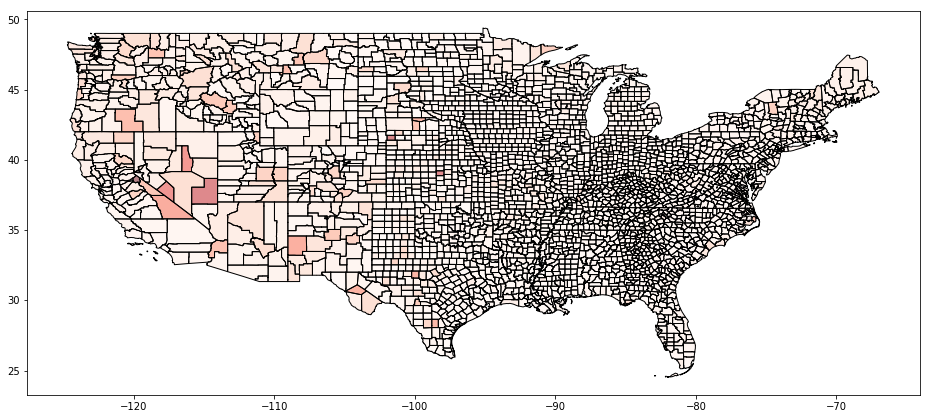

In [50]:
clipped_gdf.sort_values("SIGHTINGS", ascending=True).plot(
    column="SIGHTINGS_PER_CAPITA",
    cmap='Reds',
    figsize=(16, 8)
)

### Output the results

In [51]:
clipped_gdf.to_file("./output/sightings-by-county.geojson")

In [52]:
clipped_gdf.to_file("./output/sightings-by-county.shp")